# 1. Library

In [226]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
%matplotlib inline
import seaborn as sns
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import random
from scipy.stats import uniform, randint

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, GridSearchCV
from sklearn import metrics
from sklearn.impute import KNNImputer
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.preprocessing import StandardScaler


from imblearn.over_sampling import SMOTE

# 2. Import dataset

In [227]:
df_train = pd.read_csv('../split_data/train21.csv')
df_test = pd.read_csv('../split_data/test21.csv')

# Assuming df_train and df_test are your DataFrames
df_train.drop(['Unnamed: 0'], axis=1, inplace=True)
df_test.drop(['Unnamed: 0'], axis=1, inplace=True)

print('Shape of df_train: {}'.format(df_train.shape))
print('Shape of df_test: {}'.format(df_test.shape))


Shape of df_train: (3785, 19)
Shape of df_test: (2911, 19)


# 3. Exploratory Data Analysis

## 3.1. Distribution of Target Label

Text(0.5, 1.0, 'Distribution of Target Label in df_train')

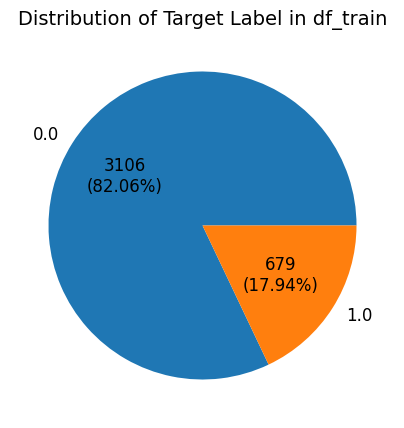

In [228]:
plt.figure(figsize=(5,5))

def auto_fmt(value):
    return '{:.0f}\n({:.2f}%)'.format(df_train['benh21'].value_counts().sum()*value/100,value)

count_label_dftrain = df_train['benh21'].value_counts().rename_axis('benh21').reset_index(name='Counts')

fig = plt.gcf()
plt.pie(x=count_label_dftrain['Counts'], labels=count_label_dftrain['benh21'], autopct=auto_fmt, textprops={'fontsize': 12})
plt.title('Distribution of Target Label in df_train',  fontsize = 14)

In [229]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3785 entries, 0 to 3784
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   d_mom_hcgb              1167 non-null   float64
 1   d_mom_pappa             1134 non-null   float64
 2   d_khoangsangsaugay      996 non-null    float64
 3   chieudaidaumong         1346 non-null   float64
 4   tuoithainhi1            2097 non-null   float64
 5   co_khoangsangsaugay     2140 non-null   float64
 6   benh21                  3785 non-null   float64
 7   tuoime                  3755 non-null   float64
 8   t_mom_ue3               561 non-null    float64
 9   t_mom_afp               524 non-null    float64
 10  t_mom_hcg               537 non-null    float64
 11  tuoithainhi2            2437 non-null   float64
 12  nguc_nhiptimthai        2581 non-null   float64
 13  dau_naothatben          2087 non-null   float64
 14  mat_xuongsongmui        1716 non-null   

In [230]:
def find_col_dtypes(data, ord_th):
    cols_num = data.select_dtypes("number").columns.to_list()
    cols_cat = data.select_dtypes("object").columns.to_list()

    ordinals = [col for col in cols_num if data[col].nunique() < ord_th]

    cols_num = [col for col in cols_num if col not in ordinals]

    return cols_num, ordinals, cols_cat

cols_num, ordinals, cols_cat = find_col_dtypes(df_train, 3)

print(f"Num Cols: {cols_num}")
print(f"Cat Cols: {cols_cat}")
print(f"Ordinal Cols: {ordinals}")

Num Cols: ['d_mom_hcgb', 'd_mom_pappa', 'd_khoangsangsaugay', 'chieudaidaumong', 'tuoithainhi1', 'co_khoangsangsaugay', 'tuoime', 't_mom_ue3', 't_mom_afp', 't_mom_hcg', 'tuoithainhi2', 'nguc_nhiptimthai', 'dau_naothatben', 'mat_xuongsongmui', 'dau_duongkinhluongdinh', 'bung_chuvivongbung', 'chi_chieudaixuongdui', 'dau_chuvidau']
Cat Cols: []
Ordinal Cols: ['benh21']


In [231]:
df_train = df_train.reindex(columns=[col for col in df_train.columns if col != 'benh21'] + ['benh21'])
df_train.columns

Index(['d_mom_hcgb', 'd_mom_pappa', 'd_khoangsangsaugay', 'chieudaidaumong',
       'tuoithainhi1', 'co_khoangsangsaugay', 'tuoime', 't_mom_ue3',
       't_mom_afp', 't_mom_hcg', 'tuoithainhi2', 'nguc_nhiptimthai',
       'dau_naothatben', 'mat_xuongsongmui', 'dau_duongkinhluongdinh',
       'bung_chuvivongbung', 'chi_chieudaixuongdui', 'dau_chuvidau', 'benh21'],
      dtype='object')

## 3.2. Missing Value Analysis

In [232]:
df_train_num = df_train.drop(['benh21'], axis=1)

In [233]:
for i in df_train_num.columns:
    miss= df_train_num[i].isnull().sum()
    cout= miss/df_train_num.shape[0]*100
    print(">%s miss %d (%.3f%%)"%(i,miss,cout))

>d_mom_hcgb miss 2618 (69.168%)
>d_mom_pappa miss 2651 (70.040%)
>d_khoangsangsaugay miss 2789 (73.686%)
>chieudaidaumong miss 2439 (64.439%)
>tuoithainhi1 miss 1688 (44.597%)
>co_khoangsangsaugay miss 1645 (43.461%)
>tuoime miss 30 (0.793%)
>t_mom_ue3 miss 3224 (85.178%)
>t_mom_afp miss 3261 (86.156%)
>t_mom_hcg miss 3248 (85.812%)
>tuoithainhi2 miss 1348 (35.614%)
>nguc_nhiptimthai miss 1204 (31.810%)
>dau_naothatben miss 1698 (44.861%)
>mat_xuongsongmui miss 2069 (54.663%)
>dau_duongkinhluongdinh miss 1137 (30.040%)
>bung_chuvivongbung miss 1233 (32.576%)
>chi_chieudaixuongdui miss 1156 (30.542%)
>dau_chuvidau miss 1407 (37.173%)


<Figure size 1000x600 with 0 Axes>

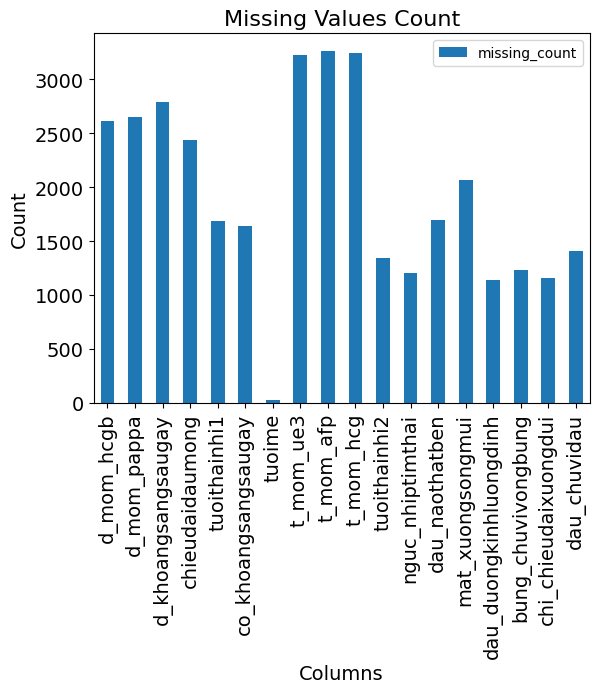

In [234]:
plt.figure(figsize=(10, 6))

df_train_miss = df_train_num.isna().sum()
df_train_miss = df_train_miss.reset_index()
df_train_miss.columns = ['feature', 'missing_count']
df_train_miss = df_train_miss.loc[df_train_miss['missing_count'] > 0]

df_train_miss.plot.bar(x='feature', y='missing_count')

plt.title('Missing Values Count', fontsize=16)
plt.xlabel('Columns', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.tick_params(axis='x', which='major', labelsize=14)
plt.tick_params(axis='y', which='major', labelsize=14)
plt.show()

## 3.3. Descritpive Analysis

In [235]:
df_train_num.describe(include='all').transpose()

,count,mean,std,min,25%,50%,75%,max
d_mom_hcgb,1167.0,2.138850,1.555715,0.0600,0.963500,1.6630,3.08300,7.3700
d_mom_pappa,1134.0,0.685864,0.449484,0.0680,0.370000,0.5555,0.88975,2.7630
d_khoangsangsaugay,996.0,1.671396,0.863606,0.2000,1.100000,1.4000,1.90000,5.8000
chieudaidaumong,1346.0,62.966976,8.626813,36.0000,57.000000,63.0000,69.00000,93.0000
tuoithainhi1,2097.0,58.946113,29.452777,13.0000,32.000000,54.0000,89.00000,97.0000
co_khoangsangsaugay,2140.0,2.568916,1.732352,0.2000,1.300000,2.3000,3.50000,47.0000
tuoime,3755.0,31.197870,6.054758,17.0000,27.000000,31.0000,36.00000,55.0000
t_mom_ue3,561.0,0.844510,0.355559,0.0705,0.590700,0.7900,1.07000,2.1100
t_mom_afp,524.0,0.872643,0.321150,0.1711,0.653475,0.8300,1.05000,2.0514
t_mom_hcg,537.0,1.647933,0.971337,0.0600,0.933300,1.4600,2.16890,5.6200


## 3.4. Histogram Analysis for Skewness

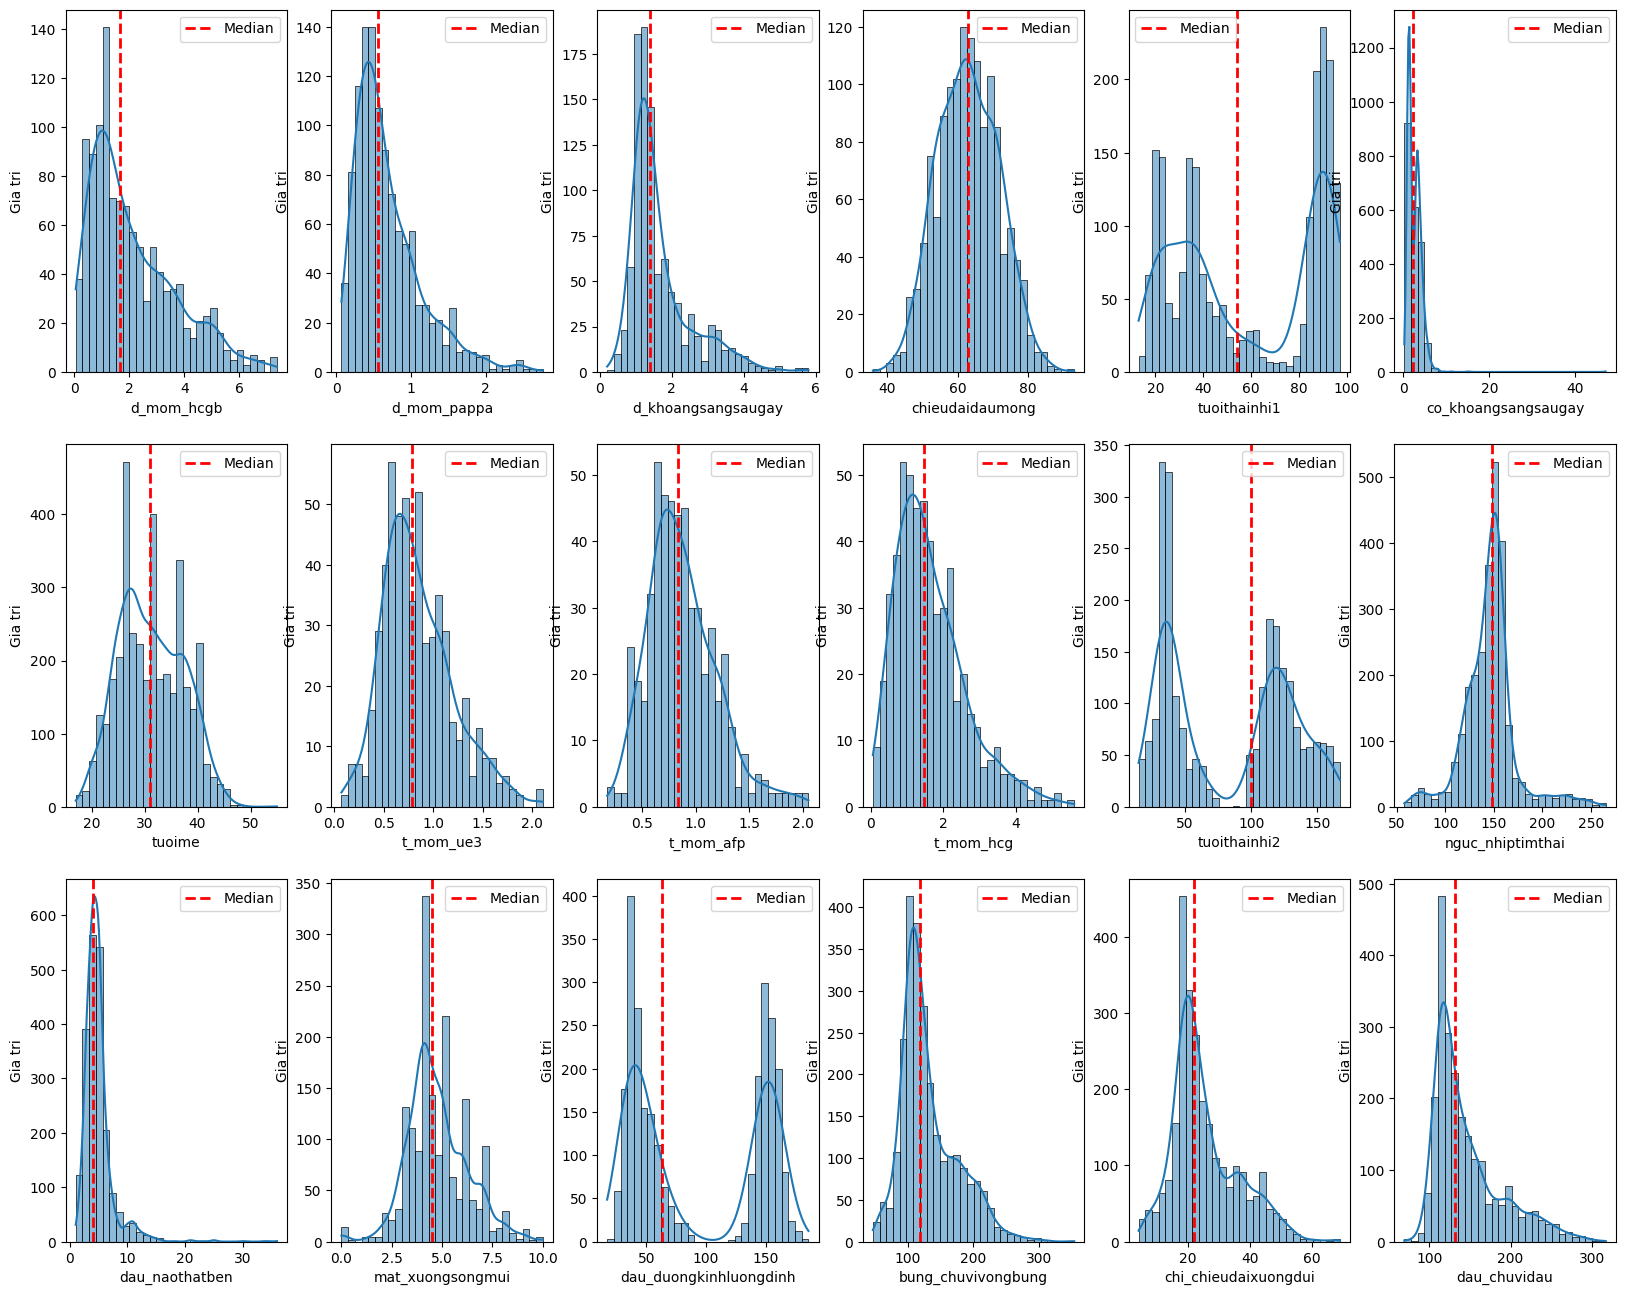

In [236]:
fig, axs = plt.subplots(3, 6, figsize=(20, 16))

for i in range(18):
    column_data = df_train_num.iloc[:, i]
    m, n = divmod(i, 6)
    sns.histplot(column_data, bins=30, kde=True, ax=axs[m, n])
    axs[m, n].axvline(column_data.median(), color='r', linewidth=2, linestyle='--', label='Median')
    axs[m, n].set(xlabel=df_train_num.columns[i], ylabel='Gia tri')
    axs[m, n].legend()

plt.show()

## 3.5. Boxplot Analysis for Outliers

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

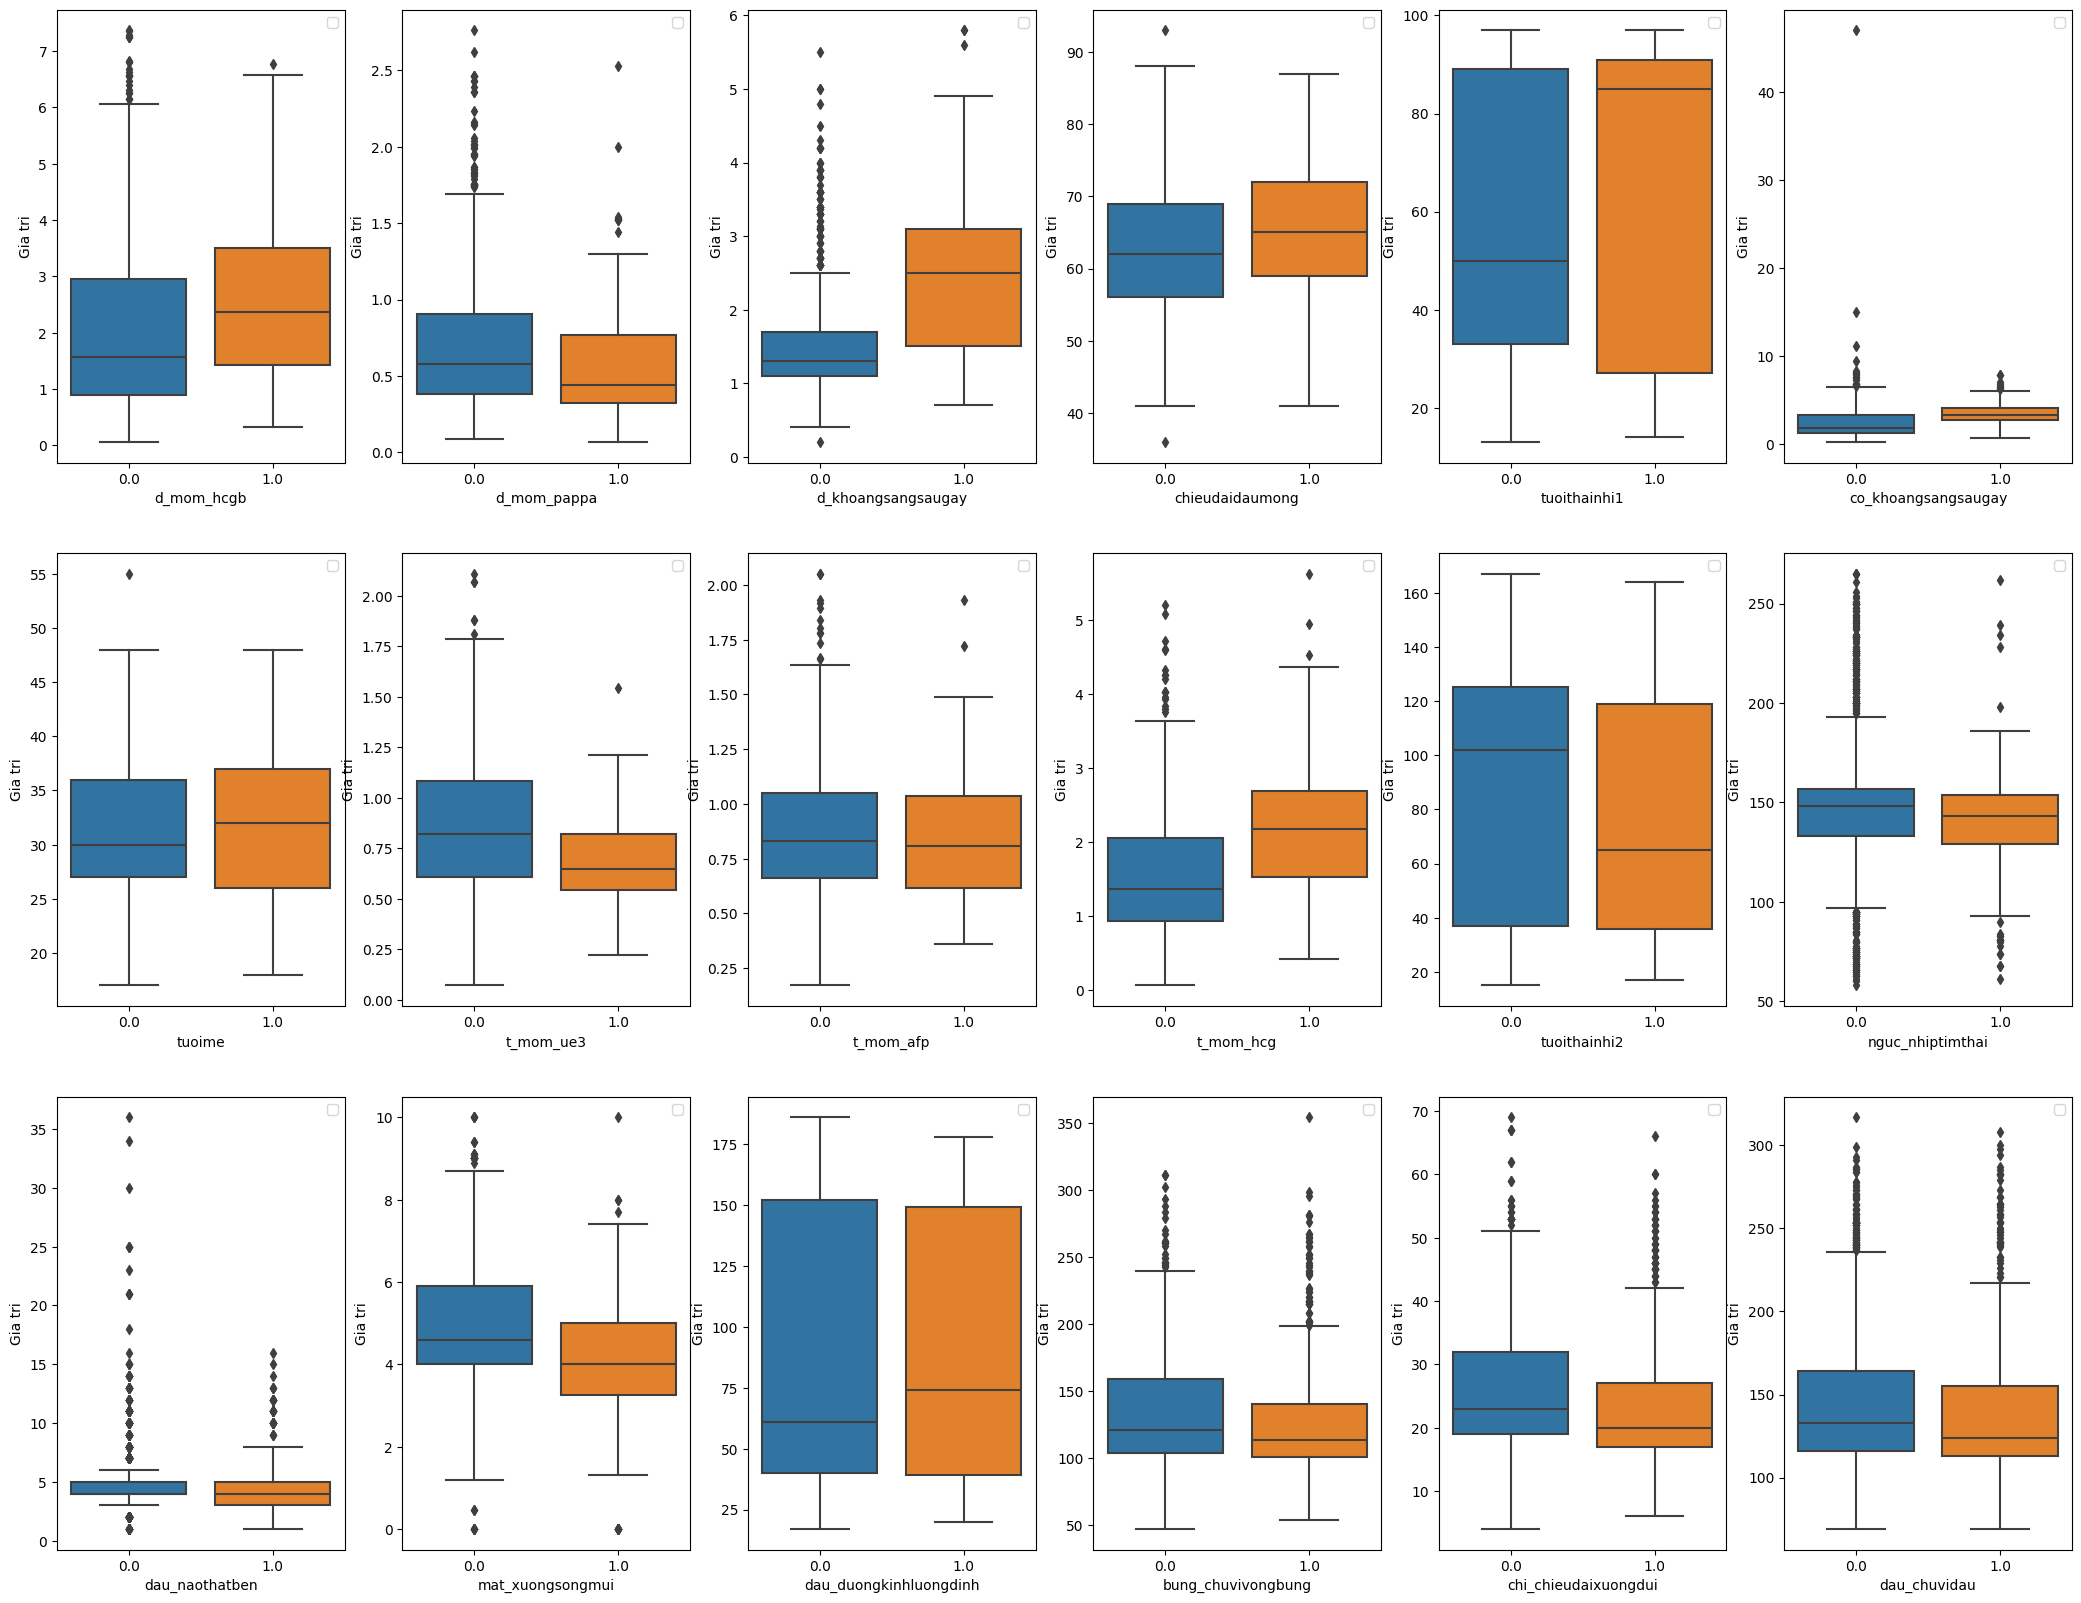

In [237]:
fig, axs = plt.subplots(3,6,figsize=(26, 20))
m = 0
n = 0
for i in range(18):
  sns.boxplot(x="benh21",y=df_train_num.columns[i],data=df_train, ax = axs[m, n])
  axs[m, n].set(xlabel= df_train_num.columns[i], ylabel= 'Gia tri')
  axs[m, n].legend()
  if n == 5:  # Change the condition to 5 to match the number of columns in axs
    m += 1
    n = 0
  else:
    n += 1

# 4. Data Pre-processing for Model Data

## 4.1. Missing Value Imputation - kNN Imputer

In [238]:
df_test.drop(['benh21'], axis=1, inplace=True)
df_test.shape

(2911, 18)

In [239]:
imputer = KNNImputer(n_neighbors=25)

df_train_imputed = pd.DataFrame(imputer.fit_transform(df_train[df_train_num.columns]), columns=df_train_num.columns)
df_test_imputed = pd.DataFrame(imputer.transform(df_test[df_train_num.columns]), columns=df_train_num.columns)

In [240]:
# Check missing value
df_train_null = df_train_imputed[df_train_imputed.isnull().any(axis=1)]
df_test_null = df_test_imputed[df_test_imputed.isnull().any(axis=1)]

print('After using KNNImputation, the number of missing value records in train set : {}'.format(df_train_null.shape[0]))
print('After using KNNImputation, the number of missing value records in test set: {}'.format(df_test_null.shape[0]))

print('Shape of the train set : {}'.format(df_train_imputed.shape))
print('Shape of the test set : {}'.format(df_test_imputed.shape))

After using KNNImputation, the number of missing value records in train set : 0
After using KNNImputation, the number of missing value records in test set: 0
Shape of the train set : (3785, 18)
Shape of the test set : (2911, 18)


In [241]:
df_train_2 = df_train.drop(df_train_num.columns, axis=1)
df_train_2 = pd.concat ([df_train_2, df_train_imputed], axis=1)

df_test_2 = df_test.drop(df_train_num.columns, axis=1)
df_test_2 = pd.concat ([df_test_2, df_test_imputed], axis=1)

print('Shape of the Train data set : {}'.format(df_train_2.shape))
print('Shape of the Test data set : {}'.format(df_test_2.shape))

Shape of the Train data set : (3785, 19)
Shape of the Test data set : (2911, 18)


## 4.2. Data Standarization for Numercial Features

In [242]:
scaler = StandardScaler()

index = df_train_2.index
scaler_train = scaler.fit_transform(df_train_2[df_train_num.columns])
scaler_df_train = pd.DataFrame(scaler_train, columns=df_train_num.columns)
scaler_df_train.index = index
print('Shape of Scaled Train Data Set: {}'.format(scaler_df_train.shape))

index = df_test_2.index
scaler_test = scaler.transform(df_test_2[df_train_num.columns])
scaler_df_test = pd.DataFrame(scaler_test, columns=df_train_num.columns)
scaler_df_test.index = index
print('Shape of Scaled Test Data Set: {}'.format(scaler_df_test.shape))

Shape of Scaled Train Data Set: (3785, 18)
Shape of Scaled Test Data Set: (2911, 18)


In [243]:
df_train_2 = df_train_2.drop(df_train_num.columns, axis=1)
df_train_2 = pd.concat ([df_train_2, scaler_df_train], axis=1)

df_test_2 = df_test_2.drop(df_train_num.columns, axis=1)
df_test_2 = pd.concat ([df_test_2, scaler_df_test], axis=1)

print('Shape of the Train data set : {}'.format(df_train_2.shape))
print('Shape of the Test data set : {}'.format(df_test_2.shape))

Shape of the Train data set : (3785, 19)
Shape of the Test data set : (2911, 18)


## 4.3. SelectKBest Method from SKLearn for Feature Selection

In [244]:
# split the data -> training and testing data for model training
train = df_train_2.drop(['benh21'], axis=1)
test = df_train_2['benh21']

# Rename
test.columns = ['benh21']

In [245]:
threshold = 0.1
t_score = 5

# Initiate the SelectKBest function
# classification: chi2, f_classif, mutual_info_classif
fs = SelectKBest(score_func=f_classif, k=len(train.columns))

# feature selection
X_selected = fs.fit_transform(train, test.values)
print('Before SelectKBest = {}'.format(train.shape))
print('=' * 50)

new_features = [] # features less than the p-values
drop_features = [] # features higher than the p-values

for i in range(len(train.columns)):
    print('{}: F-Score = {:.3f}, p-value = {:.3f}'.format(train.columns[i], fs.scores_[i], fs.pvalues_[i]))
    if fs.pvalues_[i] <= threshold and fs.scores_[i] >= t_score:
        new_features.append(train.columns[i])
    else:
        drop_features.append(train.columns[i])

X_selected_final =  pd.DataFrame(X_selected)
X_selected_final.columns = train.columns
X_selected_final = X_selected_final[new_features]

print('=' * 50)
print('After SelectKBest = {}'.format(X_selected_final.shape))
print('Drop-out Features = {}'.format(len(drop_features)))

Before SelectKBest = (3785, 18)
d_mom_hcgb: F-Score = 22.244, p-value = 0.000
d_mom_pappa: F-Score = 8.663, p-value = 0.003
d_khoangsangsaugay: F-Score = 102.379, p-value = 0.000
chieudaidaumong: F-Score = 20.702, p-value = 0.000
tuoithainhi1: F-Score = 2.415, p-value = 0.120
co_khoangsangsaugay: F-Score = 103.019, p-value = 0.000
tuoime: F-Score = 10.533, p-value = 0.001
t_mom_ue3: F-Score = 35.965, p-value = 0.000
t_mom_afp: F-Score = 2.167, p-value = 0.141
t_mom_hcg: F-Score = 17.776, p-value = 0.000
tuoithainhi2: F-Score = 0.488, p-value = 0.485
nguc_nhiptimthai: F-Score = 11.336, p-value = 0.001
dau_naothatben: F-Score = 0.051, p-value = 0.821
mat_xuongsongmui: F-Score = 37.094, p-value = 0.000
dau_duongkinhluongdinh: F-Score = 5.382, p-value = 0.020
bung_chuvivongbung: F-Score = 0.476, p-value = 0.490
chi_chieudaixuongdui: F-Score = 5.879, p-value = 0.015
dau_chuvidau: F-Score = 0.027, p-value = 0.868
After SelectKBest = (3785, 12)
Drop-out Features = 6


In [246]:
drop_features

['tuoithainhi1',
 't_mom_afp',
 'tuoithainhi2',
 'dau_naothatben',
 'bung_chuvivongbung',
 'dau_chuvidau']

In [247]:
new_features

['d_mom_hcgb',
 'd_mom_pappa',
 'd_khoangsangsaugay',
 'chieudaidaumong',
 'co_khoangsangsaugay',
 'tuoime',
 't_mom_ue3',
 't_mom_hcg',
 'nguc_nhiptimthai',
 'mat_xuongsongmui',
 'dau_duongkinhluongdinh',
 'chi_chieudaixuongdui']

## 4.4. Oversampling with SMOTE

In [248]:
# Drop out low informative features 
train = train.drop(drop_features, axis=1)
df_train_2  = df_train_2.drop(drop_features, axis=1)
df_test_2  = df_test_2.drop(drop_features, axis=1)

In [249]:
X_train, X_test, y_train, y_test = train_test_split(train, test, test_size=0.3)

print('Shape of train : {}'.format(X_train.shape))
print('Shape of test : {}'.format(X_test.shape))
print('='*10)
print('Shape of df_train (including target): {}'.format(df_train_2.shape))
print('Shape of df_test: {}'.format(df_test_2.shape))

Shape of train : (2649, 12)
Shape of test : (1136, 12)
Shape of df_train (including target): (3785, 13)
Shape of df_test: (2911, 12)


In [250]:
smote = SMOTE()

X_smote, y_smote = smote.fit_resample(X_train, y_train)
print("Length of original data is ",len(df_train_2))
print("True data in original data: {:.2%}".format(len(y_train[y_train==1])/len(y_train)))
print("False data in original data: {:.2%}".format(len(y_train[y_train==0])/len(y_train)))
print("Length of oversampled data is ",len(X_smote))
print("True data in oversampled data: {:.2%}".format(len(y_smote[y_smote==1])/len(y_smote)))
print("False data in oversampled data: {:.2%}".format(len(y_smote[y_smote==0])/len(y_smote)))

Length of original data is  3785
True data in original data: 17.44%
False data in original data: 82.56%
Length of oversampled data is  4374
True data in oversampled data: 50.00%
False data in oversampled data: 50.00%


## 4.6. Saving data (preprocessing)

In [251]:
final_trainset = pd.concat([X_smote, y_smote], axis=1)
final_trainset.to_csv('final_trainset.csv', index=False)

final_testset = pd.concat([X_test, y_test], axis=1)
final_testset.to_csv('final_testset.csv', index=False)